## Computer Vision Lab ##

Through these notebooks, we will explore different important techniques, approaches, and uses of deep learning (especially Convolutional Neural Networks) for addressing computer vision labs.

We will explore the following:

- How to create a CNN to classify digits using MNIST dataset
- Use transfer learning concepts to fine-tune pretrained models included in Pytorch
- Different visualization techniques
- Semantic segmentation

### Assignments ###

#### Mandatory: ####

- Compare CNN with an MLP
- Calculate, plot, analyse, and compare different metrics 
    - Loss, Accuracy, Precision, Recall, F1-score (when possible) --> Precision, recall, and F1-score are normally used in binary classification
- Fine-tune pretrained models:
    - by freezing weights
    - reconstructing the layers
- Data augmentation and pre-process
    - For example dataset (bees and ants)
    - For image (mario level)
    
#### Advanced: ####

- Segmentation:
    - Use Mask R-CNN (or other type of network) to do instance segmentation 
- CNN Visualization
    - Apply occlusion to gather heatmap
    - Do either:
        - Visualize through Saliency maps (vanilla backpropagation saliency, or Grad-CAM, or Score-CAM)
        - **OR**
        - Visualize a pre-trained model with Deconvnets
        
#### Optional/if wanted: ####
- Apply CNN to video data 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the Dataset (MNIST)

We will use the pytorch dataset and dataloader as seen in the previous lab. We will apply some needed transformation to the data

In [4]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes (0 to 9)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

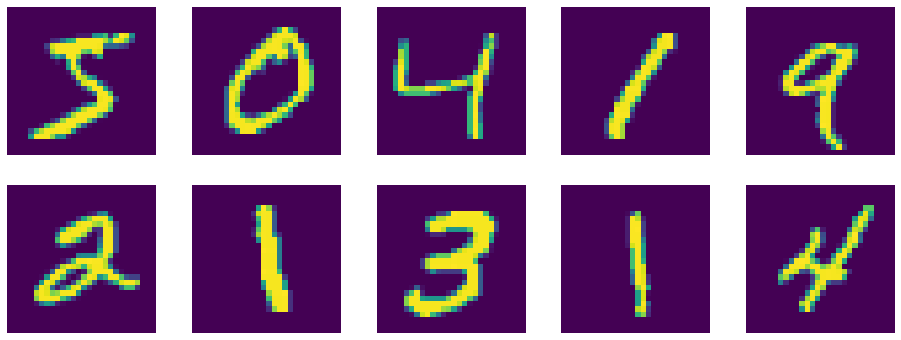

In [5]:
# The MNIST dataset is the handwritten dataset.
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset[i]
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

# Create the model classes

In [6]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5) # 6 channels and kernel_size 5
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False): # [batch_size, channel, width, height] - [64, 1, 28, 28]
        # First CONV
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) # downdsample the data by half
        
        # Second CONV
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) # downdsample the data by half
        # [64, 6, 4, 4]
        
#         x = x.view(-1, self.n_feature*4*4)
        x = self.flatten(x) # [64, n_feature * 4 * 4]
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

## Lets go step by step ##

In [22]:
tensor = torch.rand([1, 1, 28, 28]) #Batch size, channel, width, height (what the network expect)
print(tensor.shape)

torch.Size([1, 1, 28, 28])


In [25]:
conv_1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
relu_1 = F.relu
max_pool_1 = nn.MaxPool2d(kernel_size=2)

result = conv_1(tensor)
print("after conv1: ", result.shape) 
#Tensor is reshaped from [1, 1, 28, 28] to [1, 6, 24, 24]
# 6 are the number of out_channels specified
# and it reduces w and h to 24, 24 because of the kernel_size (kernel_size - 1) and stride (stride = 1)

result = relu_1(result)
print("after relu1: ", result.shape)

result = max_pool_1(result)
print("after max_pooling_1: ", result.shape) 
# tensor is reshaped from [1, 6, 24, 24] to [1, 6, 12, 12]
# max pooling downsamples dividing by kernel_size

after conv1:  torch.Size([1, 6, 24, 24])
after relu1:  torch.Size([1, 6, 24, 24])
after max_pooling_1:  torch.Size([1, 6, 12, 12])


In [15]:
conv_2 = nn.Conv2d(in_channels=6, out_channels=6, kernel_size=5)
relu_2 = F.relu
max_pool_2 = nn.MaxPool2d(kernel_size=2)

result = conv_2(result)
print("after conv2: ", result.shape)

result = relu_2(result)
print("after relu2: ", result.shape)

result = max_pool_2(result)
print("after max_pooling_2: ", result.shape)
print("shape is [1, 6*4*4]: ", 6*4*4)

after conv2:  torch.Size([1, 6, 8, 8])
after relu2:  torch.Size([1, 6, 8, 8])
after max_pooling_2:  torch.Size([1, 6, 4, 4])
shape is [1, 6*4*4]:  96


In [16]:
flatten_operation = nn.Flatten()

result_flattened = flatten_operation(result)
print("after flattening: ", result_flattened.shape)

result_with_view = result.view(-1, 6*4*4)
print("after view: ", result_with_view.shape)

after flattening:  torch.Size([1, 96])
after view:  torch.Size([1, 96])


## Train and Test loop

In [17]:
def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device) # [64, 1, 28, 28]
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [18]:
accuracy_list = []
loss_list = []

def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    loss_list.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train a ConvNet with the same number of parameters

In [19]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
print(model_cnn)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=96, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.308290
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.291231
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.366576
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.292181
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.301694
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.267069
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.290261
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.118426
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.264227
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.146818

Test set: Average loss: 0.1322, Accuracy: 9590/10000 (96%)



## PLOT Loss, Accuracy, and compare! ##

# Create and Train a small fully-connected network on the same task

Compare and plot as well for it!

## Experiment ##

### What happens when the data (imgs) does not make sense anymore - all assumptions are removed ###

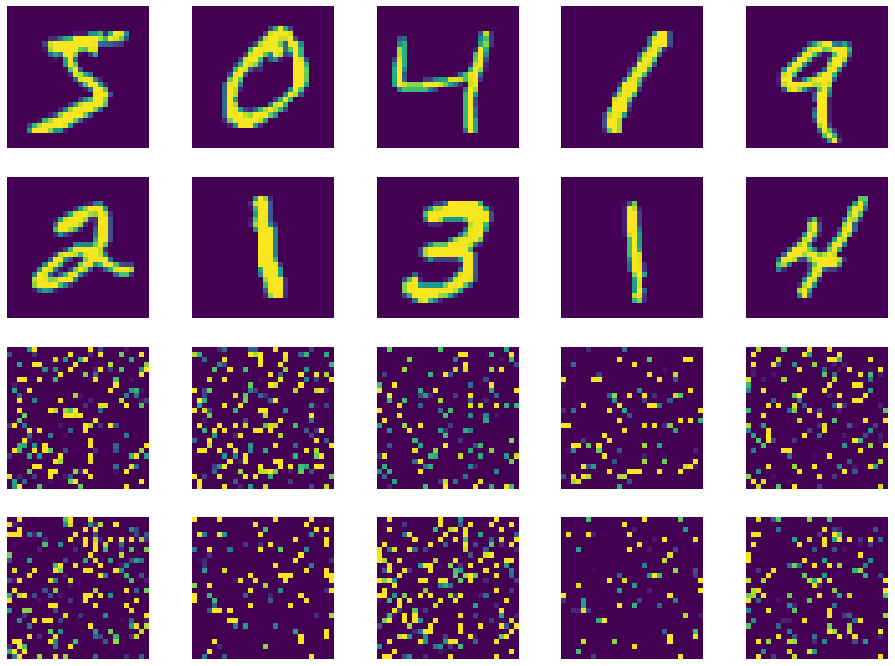

In [20]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset[i]
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

In [21]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.305727
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.259737
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.173458
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.787003
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.406316
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.170288
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.784760
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.629750
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.631064
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.428534

Test set: Average loss: 0.5607, Accuracy: 8245/10000 (82%)



## Do the same with the MLP ##

In [ ]:
# create network, train, compare!

## What to do next? ##

- Change the task
- upload your handwriten work.
- Fine-tune the network so it learn your handwritting?